# Lib

In [1]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from collections import Counter
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna
import shap
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"Seed set to {seed}")
set_seed(42)

Seed set to 42


In [2]:
train = pd.read_csv('D:/Data Quest Challenge DSI/training_dataset.csv')
test = pd.read_csv('D:/Data Quest Challenge DSI/validation_set.csv')

train.drop(['customer_number'], inplace=True, axis=1)
test.drop(['customer_number'], inplace=True, axis=1)

In [3]:
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22916 entries, 0 to 22915
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   usia                          22916 non-null  int64  
 1   pekerjaan                     22916 non-null  object 
 2   status_perkawinan             22916 non-null  object 
 3   pendidikan                    22916 non-null  object 
 4   gagal_bayar_sebelumnya        22916 non-null  object 
 5   pinjaman_rumah                22916 non-null  object 
 6   pinjaman_pribadi              22916 non-null  object 
 7   jenis_kontak                  22916 non-null  object 
 8   bulan_kontak_terakhir         22916 non-null  object 
 9   hari_kontak_terakhir          22916 non-null  object 
 10  jumlah_kontak_kampanye_ini    22916 non-null  int64  
 11  hari_sejak_kontak_sebelumnya  22916 non-null  int64  
 12  jumlah_kontak_sebelumnya      22916 non-null  int64  
 13  h

In [4]:
# Check for missing values in both train and test datasets
print("Missing values in training dataset:")
print(train.isna().sum())

print("\nMissing values in validation dataset:")
print(test.isna().sum())

# Print total number of rows with missing values in each dataset
print("\nTotal rows with missing values:")
print(f"Training dataset: {train.isna().any(axis=1).sum()} out of {train.shape[0]} rows")
print(f"Validation dataset: {test.isna().any(axis=1).sum()} out of {test.shape[0]} rows")

Missing values in training dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah                  0
pinjaman_pribadi                0
jenis_kontak                    0
bulan_kontak_terakhir           0
hari_kontak_terakhir            0
jumlah_kontak_kampanye_ini      0
hari_sejak_kontak_sebelumnya    0
jumlah_kontak_sebelumnya        0
hasil_kampanye_sebelumnya       0
tingkat_variasi_pekerjaan       0
indeks_harga_konsumen           0
indeks_kepercayaan_konsumen     0
suku_bunga_euribor_3bln         0
jumlah_pekerja                  0
pulau                           0
berlangganan_deposito           0
dtype: int64

Missing values in validation dataset:
usia                            0
pekerjaan                       0
status_perkawinan               0
pendidikan                      0
gagal_bayar_sebelumnya          0
pinjaman_rumah              

# EDA

gagal_bayar_sebelumnya cuman ada 2 baris yang classnya yes

In [5]:
train.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,...,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau,berlangganan_deposito
0,63,sosial media specialis,menikah,Pendidikan Tinggi,no,yes,no,cellular,jul,fri,...,999,0,nonexistent,-1.7,94.215,-40.3,0.885,4991.6,Papua,1
1,43,teknisi,menikah,Pendidikan Tinggi,no,yes,no,cellular,nov,fri,...,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,Sulawesi,0
2,29,sosial media specialis,lajang,Pendidikan Tinggi,no,yes,yes,cellular,jul,thu,...,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,Papua,0
3,40,pekerja kasar,menikah,SMA,no,no,no,telephone,may,wed,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,Sumatera,1
4,40,sosial media specialis,lajang,Pendidikan Tinggi,no,no,no,cellular,aug,wed,...,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,Bali,0


there's no class for yes

In [6]:
test.head()

,usia,pekerjaan,status_perkawinan,pendidikan,gagal_bayar_sebelumnya,pinjaman_rumah,pinjaman_pribadi,jenis_kontak,bulan_kontak_terakhir,hari_kontak_terakhir,jumlah_kontak_kampanye_ini,hari_sejak_kontak_sebelumnya,jumlah_kontak_sebelumnya,hasil_kampanye_sebelumnya,tingkat_variasi_pekerjaan,indeks_harga_konsumen,indeks_kepercayaan_konsumen,suku_bunga_euribor_3bln,jumlah_pekerja,pulau
0,35,penyedia jasa,menikah,SMA,no,yes,yes,cellular,jul,mon,1,999,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,Jawa
1,52,teknisi,lajang,Diploma,unknown,no,no,telephone,may,thu,4,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,Papua
2,37,pekerja kasar,menikah,SMP,unknown,yes,no,telephone,may,wed,3,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,Bali
3,51,pengangguran,menikah,Diploma,no,no,no,telephone,may,tue,3,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,Sumatera
4,45,teknisi,cerai,SMA,no,yes,no,cellular,may,thu,1,999,1,failure,-1.8,92.893,-46.2,1.327,5099.1,Sumatera


In [7]:
cat_col = train.select_dtypes(include=['object']).columns.tolist()
num_col = train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", cat_col)
print(f"Jumlah kolom kategorikal: { len(cat_col) }\n")

print("Numerical columns:", num_col)
print("Jumlah kolom numerikal:", len(num_col))

Categorical columns: ['pekerjaan', 'status_perkawinan', 'pendidikan', 'gagal_bayar_sebelumnya', 'pinjaman_rumah', 'pinjaman_pribadi', 'jenis_kontak', 'bulan_kontak_terakhir', 'hari_kontak_terakhir', 'hasil_kampanye_sebelumnya', 'pulau']
Jumlah kolom kategorikal: 11

Numerical columns: ['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya', 'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan', 'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen', 'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'berlangganan_deposito']
Jumlah kolom numerikal: 10


Unique Value pendidikan: ['Pendidikan Tinggi' 'SMA' 'Tidak Tamat SD' 'SMP' 'Diploma' 'SD' 'unknown'
 'TIDAK SEKOLAH']
Unique Value pekerjaan: ['sosial media specialis' 'teknisi' 'pekerja kasar' 'manajer'
 'asisten rumah tangga' 'mahasiswa' 'penyedia jasa' 'pemilik bisnis'
 'entrepreneur' 'pengangguran' 'pensiunan' 'unknown']
Unique Value status_perkawinan: ['menikah' 'lajang' 'cerai' 'unknown']
Unique Value bulan_kontak_terakhir: ['jul' 'nov' 'may' 'aug' 'oct' 'apr' 'jun' 'sep' 'mar' 'dec']
Unique Value hari_kontak_terakhir: ['fri' 'thu' 'wed' 'tue' 'mon']
Unique Value pulau: ['Papua' 'Sulawesi' 'Sumatera' 'Bali' 'NTT' 'Jawa' 'NTB' 'Kalimantan']


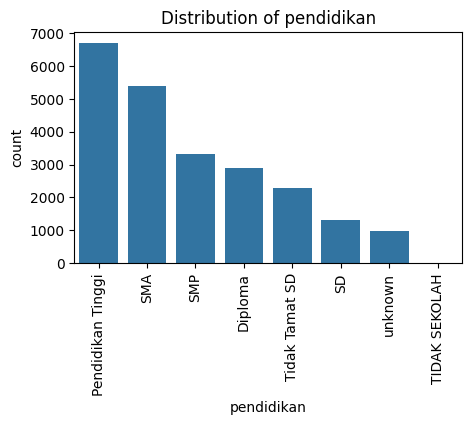

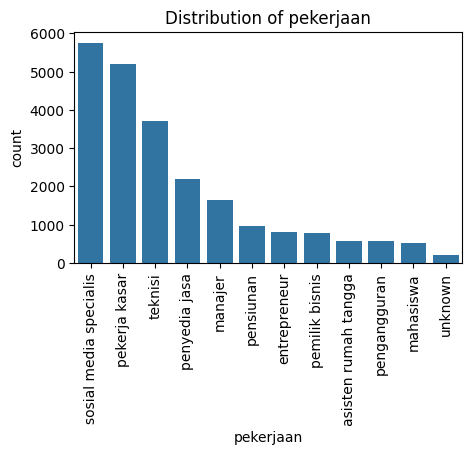

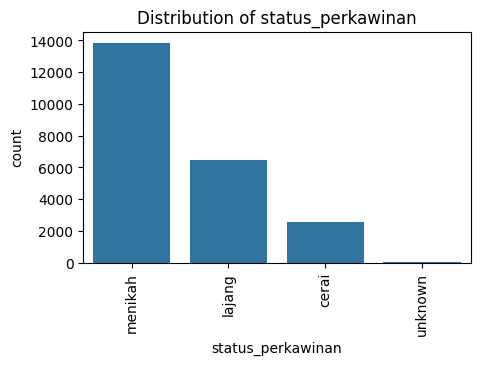

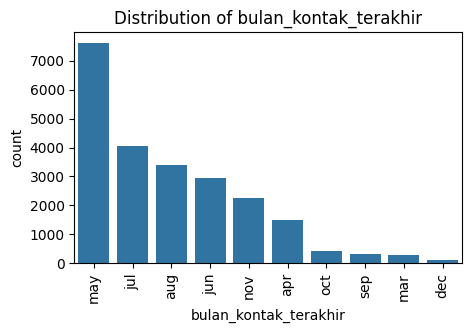

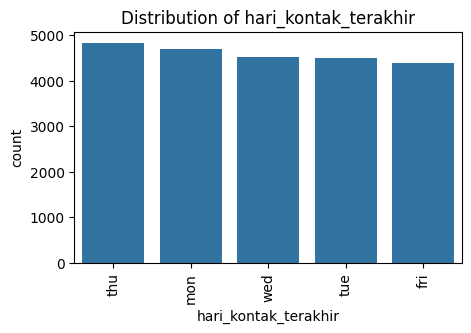

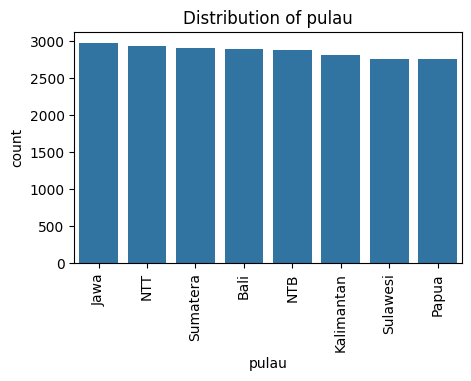

In [8]:
print("Unique Value pendidikan:", train['pendidikan'].unique())
print("Unique Value pekerjaan:", train['pekerjaan'].unique())
print("Unique Value status_perkawinan:", train['status_perkawinan'].unique())
print("Unique Value bulan_kontak_terakhir:", train['bulan_kontak_terakhir'].unique())
print("Unique Value hari_kontak_terakhir:", train['hari_kontak_terakhir'].unique())
print("Unique Value pulau:", train['pulau'].unique())

# Lookin the distribution of each categorical variable
def plot_categorical_distribution(df, column):
    plt.figure(figsize=(5, 3))
    sns.countplot(data=df, x=column, order=df[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

plot_categorical_distribution(train, 'pendidikan')
plot_categorical_distribution(train, 'pekerjaan')
plot_categorical_distribution(train, 'status_perkawinan')
plot_categorical_distribution(train, 'bulan_kontak_terakhir')
plot_categorical_distribution(train, 'hari_kontak_terakhir')
plot_categorical_distribution(train, 'pulau')

## Transforming values

Merubah semua kategori unknown menjadi NaN

In [9]:
# Replace unknown values with NaN
train['pendidikan'] = train['pendidikan'].replace(['unknown'], np.nan)
train['pekerjaan'] = train['pekerjaan'].replace(['unknown'], np.nan)
train['status_perkawinan'] = train['status_perkawinan'].replace(['unknown'], np.nan)
train['gagal_bayar_sebelumnya'] = train['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
train['pinjaman_rumah'] = train['pinjaman_rumah'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)
train['pinjaman_pribadi'] = train['pinjaman_pribadi'].replace(['unknown'], np.nan)

test['pendidikan'] = test['pendidikan'].replace(['unknown'], np.nan)
test['pekerjaan'] = test['pekerjaan'].replace(['unknown'], np.nan)
test['status_perkawinan'] = test['status_perkawinan'].replace(['unknown'], np.nan)
test['gagal_bayar_sebelumnya'] = test['gagal_bayar_sebelumnya'].replace(['unknown'], np.nan)
test['pinjaman_rumah'] = test['pinjaman_rumah'].replace(['unknown'], np.nan)
test['pinjaman_pribadi'] = test['pinjaman_pribadi'].replace(['unknown'], np.nan)

# Replace 999 with 0
train['hari_sejak_kontak_sebelumnya'] = train['hari_sejak_kontak_sebelumnya'].replace([999], 0)
test['hari_sejak_kontak_sebelumnya'] = test['hari_sejak_kontak_sebelumnya'].replace([999], 0)

In [10]:
print("Missing values in training dataset:")
print(train.isna().sum())
print("Duplicate rows in training dataset:")
print(train.duplicated().sum())

Missing values in training dataset:
usia                               0
pekerjaan                        193
status_perkawinan                 47
pendidikan                       992
gagal_bayar_sebelumnya          4745
pinjaman_rumah                   579
pinjaman_pribadi                 579
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
berlangganan_deposito              0
dtype: int64
Duplicate rows in training dataset:
78


In [11]:
print("\nMissing values in validation dataset:")
print(test.isna().sum())
print("Duplicate rows in validation dataset:")
print(test.duplicated().sum())


Missing values in validation dataset:
usia                               0
pekerjaan                         49
status_perkawinan                  9
pendidikan                       218
gagal_bayar_sebelumnya          1207
pinjaman_rumah                   125
pinjaman_pribadi                 125
jenis_kontak                       0
bulan_kontak_terakhir              0
hari_kontak_terakhir               0
jumlah_kontak_kampanye_ini         0
hari_sejak_kontak_sebelumnya       0
jumlah_kontak_sebelumnya           0
hasil_kampanye_sebelumnya          0
tingkat_variasi_pekerjaan          0
indeks_harga_konsumen              0
indeks_kepercayaan_konsumen        0
suku_bunga_euribor_3bln            0
jumlah_pekerja                     0
pulau                              0
dtype: int64
Duplicate rows in validation dataset:
7


# Preprocessing

In [12]:
train.drop_duplicates(inplace=True)
train.reset_index(drop=True, inplace=True)
print("Duplicate rows in training dataset after removal:")
print(train.duplicated().sum())
print("Duplicate rows in validation dataset after removal:")
print(test.duplicated().sum())

Duplicate rows in training dataset after removal:
0
Duplicate rows in validation dataset after removal:
7


Outliers checking

In [13]:
# Check for numerical columns 
num_cols = train.select_dtypes(include=['int64', 'float64']).columns

print("Numerical columns in training dataset:", num_cols)

Numerical columns in training dataset: Index(['usia', 'jumlah_kontak_kampanye_ini', 'hari_sejak_kontak_sebelumnya',
       'jumlah_kontak_sebelumnya', 'tingkat_variasi_pekerjaan',
       'indeks_harga_konsumen', 'indeks_kepercayaan_konsumen',
       'suku_bunga_euribor_3bln', 'jumlah_pekerja', 'berlangganan_deposito'],
      dtype='object')


<Axes: ylabel='jumlah_pekerja'>

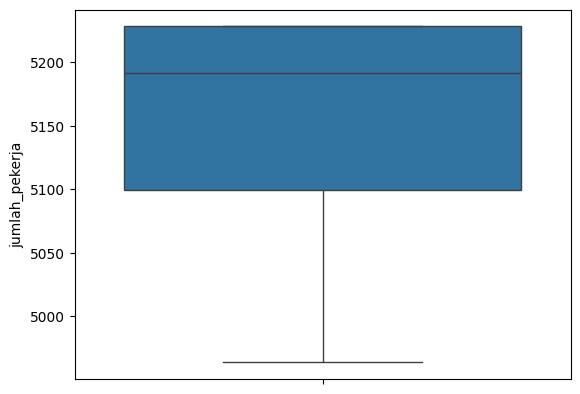

In [14]:
sns.boxplot(train['jumlah_pekerja'])

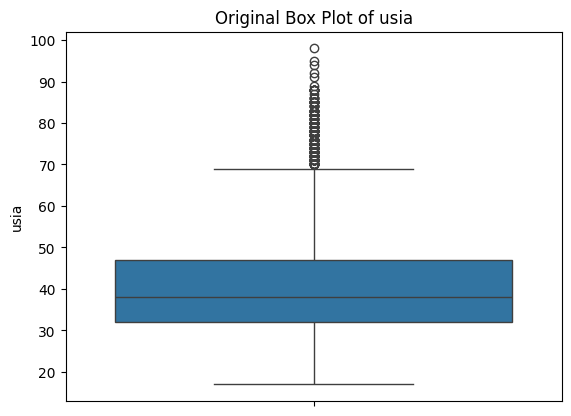

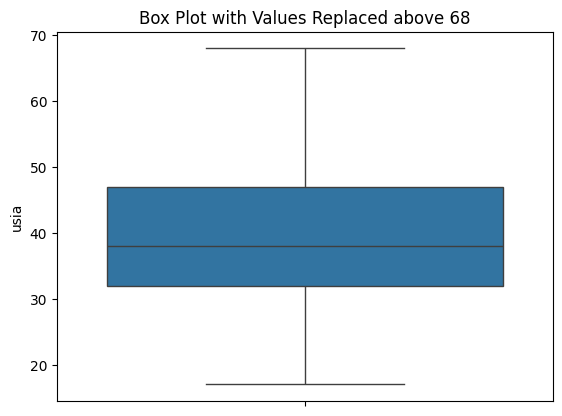

In [15]:
# Threshold atas
def replace_values_above_threshold(data_train, column, threshold):
    sns.boxplot(data_train[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()

    above_threshold = data_train[column] > threshold
    data_train.loc[above_threshold, column] = threshold

    sns.boxplot(data_train[column])
    plt.title(f'Box Plot with Values Replaced above {threshold}')
    plt.show()

    return train

train = replace_values_above_threshold(train, 'usia', 68)
# train = replace_values_above_threshold(train, 'jumlah_kontak_kampanye_ini', 6)
# train = replace_values_above_threshold(train, 'indeks_kepercayaan_konsumen', -30)

## Encoding

In [16]:
le = LabelEncoder()

# One-hot encoding for categorical variables
def one_hot_encode(df, columns):
    return pd.get_dummies(df, columns=columns, drop_first=True)

# Label pekerjaan
def label_encode(df, column):
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    return df


# Mapping Ordinal Columns
pendidikan_mapping = {
    'TIDAK SEKOLAH': 0,
    'Tidak Tamat SD': 1,
    'SD': 2,
    'SMP': 3,
    'SMA': 4,
    'Diploma': 5,
    'Pendidikan Tinggi': 6,
}

bulan_kontak_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}

hasil_mapping = {
    'failure': -1,
    'nonexistent': 0,
    'success': 1,
}

hari_kontak_mapping = {
    'mon': 1, 'tue': 2, 'wed': 3, 'thu': 4, 'fri': 5
}

binary_mapping = {
    'yes': 1,
    'no': 0
}

train['pendidikan'] = train['pendidikan'].map(pendidikan_mapping)
test['pendidikan'] = test['pendidikan'].map(pendidikan_mapping)

train['bulan_kontak_terakhir'] = train['bulan_kontak_terakhir'].map(bulan_kontak_mapping)
test['bulan_kontak_terakhir'] = test['bulan_kontak_terakhir'].map(bulan_kontak_mapping)

train['hasil_kampanye_sebelumnya'] = train['hasil_kampanye_sebelumnya'].map(hasil_mapping)
test['hasil_kampanye_sebelumnya'] = test['hasil_kampanye_sebelumnya'].map(hasil_mapping)

train['hari_kontak_terakhir'] = train['hari_kontak_terakhir'].map(hari_kontak_mapping)
test['hari_kontak_terakhir'] = test['hari_kontak_terakhir'].map(hari_kontak_mapping)

train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)

train = one_hot_encode(train, ['pulau', 'jenis_kontak', 'status_perkawinan'])
test = one_hot_encode(test, ['pulau', 'jenis_kontak', 'status_perkawinan'])
train = one_hot_encode(train, ['pekerjaan'])
test = one_hot_encode(test, ['pekerjaan'])

# train = label_encode(train, 'pekerjaan')
# test = label_encode(test, 'pekerjaan')

train = train.astype('float32')
test = test.astype('float32')

C:\Users\asus0\AppData\Local\Temp\ipykernel_33300\3197342356.py:57: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = train[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']].replace(binary_mapping)
C:\Users\asus0\AppData\Local\Temp\ipykernel_33300\3197342356.py:58: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumnya']] = test[['pinjaman_rumah', 'pinjaman_pribadi', 'gagal_bayar_sebelumn

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22838 entries, 0 to 22837
Data columns (total 37 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   usia                              22838 non-null  float32
 1   pendidikan                        21846 non-null  float32
 2   gagal_bayar_sebelumnya            18104 non-null  float32
 3   pinjaman_rumah                    22259 non-null  float32
 4   pinjaman_pribadi                  22259 non-null  float32
 5   bulan_kontak_terakhir             22838 non-null  float32
 6   hari_kontak_terakhir              22838 non-null  float32
 7   jumlah_kontak_kampanye_ini        22838 non-null  float32
 8   hari_sejak_kontak_sebelumnya      22838 non-null  float32
 9   jumlah_kontak_sebelumnya          22838 non-null  float32
 10  hasil_kampanye_sebelumnya         22838 non-null  float32
 11  tingkat_variasi_pekerjaan         22838 non-null  float32
 12  inde

## Handling missing values

### Dropping

In [18]:
train_dropped = train.dropna(axis=0, how='any')
print("\nTraining dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {train.shape} dan ukuran dataset setelah drop: {train_dropped.shape}')

test_dropped = test.dropna(axis=0, how='any')
print("\nValidation dataset after dropping rows with missing values:")
print(f'Ukuran dataset sebelum drop: {test.shape} dan ukuran dataset setelah drop: {test_dropped.shape}')


Training dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (22838, 37) dan ukuran dataset setelah drop: (16982, 37)

Validation dataset after dropping rows with missing values:
Ukuran dataset sebelum drop: (5729, 36) dan ukuran dataset setelah drop: (4284, 36)


### MICE/KNN

In [19]:
feature_cols = train_dropped.drop(['berlangganan_deposito'], axis=1).columns.tolist()

In [20]:
# Initialize imputers
mice = IterativeImputer(random_state=42)
knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# Fit MICE imputer on training data and transform both datasets
train_imputed = mice.fit_transform(train[feature_cols])
test_imputed = mice.transform(test)

# Convert back to DataFrame with original column names
train_imputed = pd.DataFrame(train_imputed, columns=train.drop(columns=['berlangganan_deposito']).columns)
train_imputed['berlangganan_deposito'] = train['berlangganan_deposito'].values
test_imputed = pd.DataFrame(test_imputed, columns=test.columns)

# Print shape of imputed datasets
print(f"Training dataset after imputation: {train_imputed.shape}")
print(f"Test dataset after imputation: {test_imputed.shape}")

Training dataset after imputation: (22838, 37)
Test dataset after imputation: (5729, 36)


# Splitting

In [21]:
X = train_imputed.drop(columns=['berlangganan_deposito'])
y = train_imputed['berlangganan_deposito']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42, shuffle=True) 

# Scaling

In [22]:
minmax = MinMaxScaler(feature_range=(0, 1))
robust = RobustScaler()
X_train_scaled = robust.fit_transform(X_train)
X_val_scaled = robust.transform(X_val)
test_scaled = robust.transform(test_imputed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)
test_scaled = pd.DataFrame(test_scaled, columns=test_imputed.columns)

# Resampling

## Over under

In [23]:
# # OVER UNDER

# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler

# # Inisialisasi undersampler untuk kelas 0
# undersampler = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Inisialisasi oversampler untuk kelas 1 dan 2
# oversampler = RandomOverSampler(sampling_strategy={1: 2000, 0: 5000}, random_state=42)

# X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# X_train_final, y_train_final = oversampler.fit_resample(X_train_resampled, y_train_resampled)

# from collections import Counter
# print("Distribusi kelas setelah resampling:", Counter(y_train_final['coppaRisk']))

# X_train = X_train_final
# y_train = y_train_final

## SMOTE

In [24]:
# smote = SMOTE(random_state=42, sampling_strategy='auto')
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
# X_val_resampled, y_val_resampled = smote.fit_resample(X_val_scaled, y_val)
# print("Distribusi kelas setelah SMOTE:")
# print(Counter(y_train_resampled))
# X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)
# X_val_resampled = pd.DataFrame(X_val_resampled, columns=X_val.columns)

# Modelling

## Training

In [25]:
# Use elasticnet with saga solver and specify l1_ratio
# For elasticnet, we need to specify both solver='saga' and l1_ratio parameter
model3 = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000, random_state=42)
model3.fit(X_train_scaled, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   random_state=42, solver='saga')

In [26]:
model2 = CatBoostClassifier(eval_metric='AUC', random_seed=42, verbose=0)
model2.fit(X_train_scaled, y_train, eval_set=(X_val_scaled, y_val))

In [27]:
# Train the model
model1 = XGBClassifier(objective="binary:logistic", eval_metric="auc", loss='logloss', random_state=42, use_label_encoder=False, verbosity=0)
model1.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=True)

[0]	validation_0-auc:0.77562
[1]	validation_0-auc:0.77530
[2]	validation_0-auc:0.78205
[3]	validation_0-auc:0.78248
[4]	validation_0-auc:0.78382
[5]	validation_0-auc:0.78470
[6]	validation_0-auc:0.78342


d:\Anaconda\envs\tf2\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[7]	validation_0-auc:0.78166
[8]	validation_0-auc:0.78191
[9]	validation_0-auc:0.78381
[10]	validation_0-auc:0.78388
[11]	validation_0-auc:0.78389
[12]	validation_0-auc:0.78404
[13]	validation_0-auc:0.78662
[14]	validation_0-auc:0.78479
[15]	validation_0-auc:0.78323
[16]	validation_0-auc:0.78214
[17]	validation_0-auc:0.78156
[18]	validation_0-auc:0.78203
[19]	validation_0-auc:0.78193
[20]	validation_0-auc:0.78212
[21]	validation_0-auc:0.78226
[22]	validation_0-auc:0.78194
[23]	validation_0-auc:0.78239
[24]	validation_0-auc:0.78213
[25]	validation_0-auc:0.78175
[26]	validation_0-auc:0.78160
[27]	validation_0-auc:0.78182
[28]	validation_0-auc:0.77990
[29]	validation_0-auc:0.77969
[30]	validation_0-auc:0.77945
[31]	validation_0-auc:0.77945
[32]	validation_0-auc:0.77937
[33]	validation_0-auc:0.77897
[34]	validation_0-auc:0.77905
[35]	validation_0-auc:0.77815
[36]	validation_0-auc:0.77775
[37]	validation_0-auc:0.77768
[38]	validation_0-auc:0.77715
[39]	validation_0-auc:0.77669
[40]	validati

AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, loss='logloss',
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

<Figure size 1000x800 with 0 Axes>

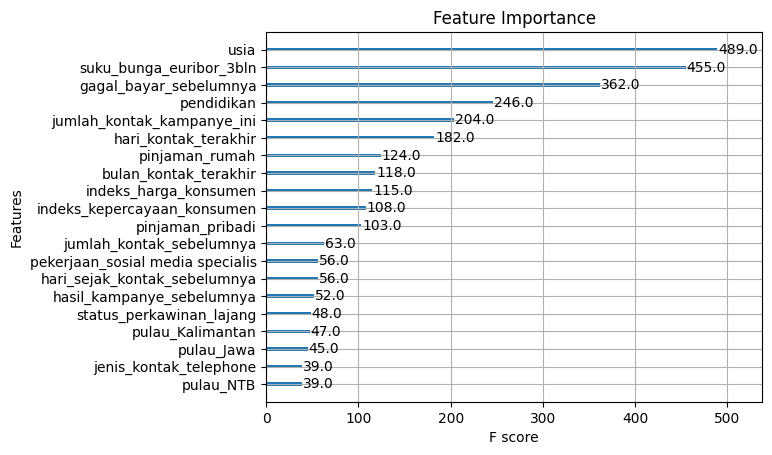

In [28]:
from xgboost import plot_importance
plt.figure(figsize=(10, 8))
plot_importance(model1, max_num_features=20, importance_type='weight', title='Feature Importance')
plt.show()

## Evaluating

Accuracy: 0.9007
ROC AUC Score: 0.7909

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      5057
         1.0       0.66      0.27      0.39       653

    accuracy                           0.90      5710
   macro avg       0.79      0.63      0.67      5710
weighted avg       0.88      0.90      0.88      5710


Confusion Matrix:
[[4965   92]
 [ 475  178]]


<Axes: >

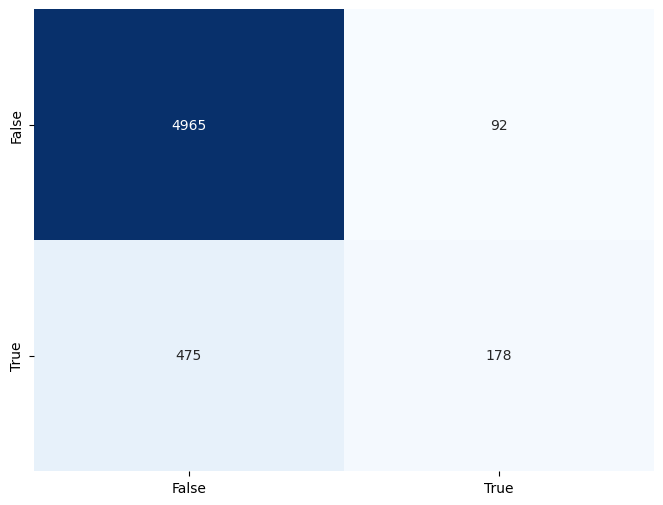

In [29]:
# Make predictions
y_pred = model2.predict(X_val_scaled)
y_pred_proba = model2.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])

Accuracy: 0.8954
ROC AUC Score: 0.7647

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      5057
         1.0       0.58      0.31      0.41       653

    accuracy                           0.90      5710
   macro avg       0.75      0.64      0.67      5710
weighted avg       0.88      0.90      0.88      5710


Confusion Matrix:
[[4909  148]
 [ 449  204]]


<Axes: >

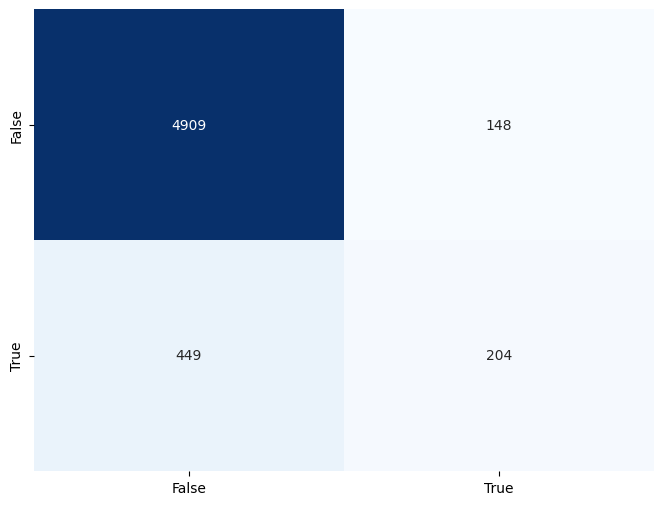

In [30]:
# Make predictions
y_pred = model1.predict(X_val_scaled)   
y_pred_proba = model1.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])

Accuracy: 0.8998
ROC AUC Score: 0.7757

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      5057
         1.0       0.68      0.24      0.35       653

    accuracy                           0.90      5710
   macro avg       0.79      0.61      0.65      5710
weighted avg       0.88      0.90      0.88      5710


Confusion Matrix:
[[4982   75]
 [ 497  156]]


<Axes: >

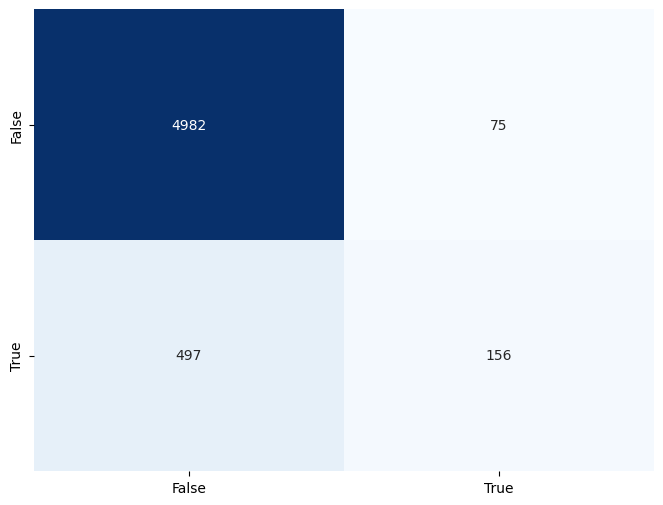

In [31]:
# Make predictions
y_pred = model3.predict(X_val_scaled)
y_pred_proba = model3.predict_proba(X_val_scaled)[:,1]

# Evaluate the model
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
conf_matrix = confusion_matrix(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(conf_matrix)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['False', 'True'], yticklabels=['False', 'True'])


# Optimizing

C:\Users\asus0\AppData\Local\Temp\ipykernel_33300\869899621.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", max_display=20)


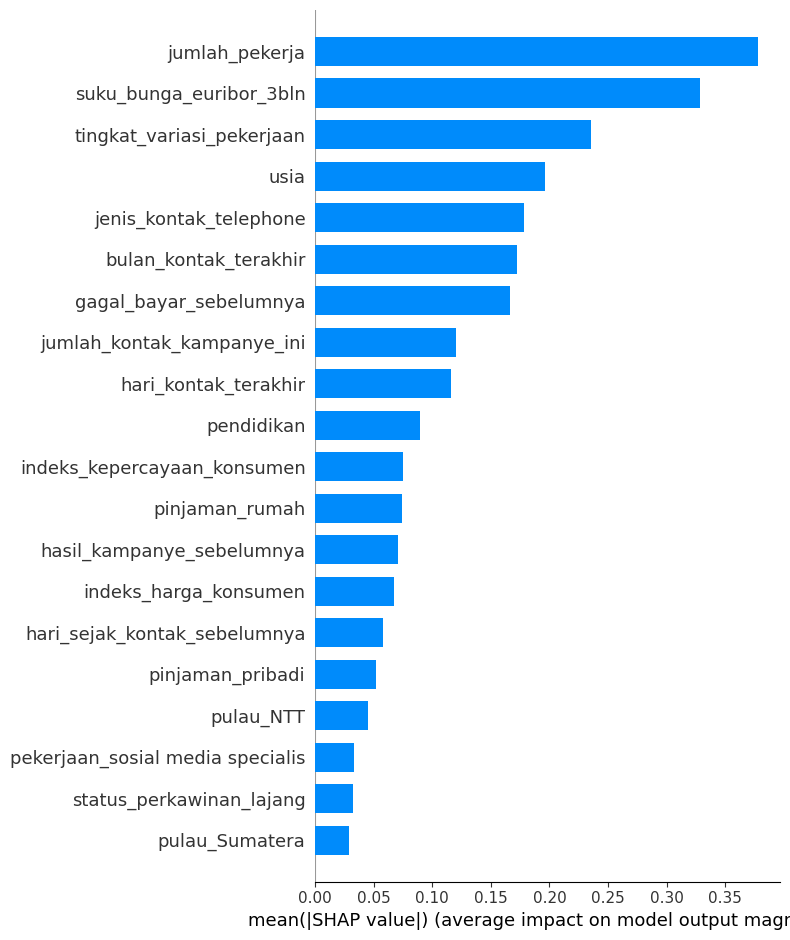

<Axes: title={'center': 'Feature Importance'}, xlabel='F score', ylabel='Features'>

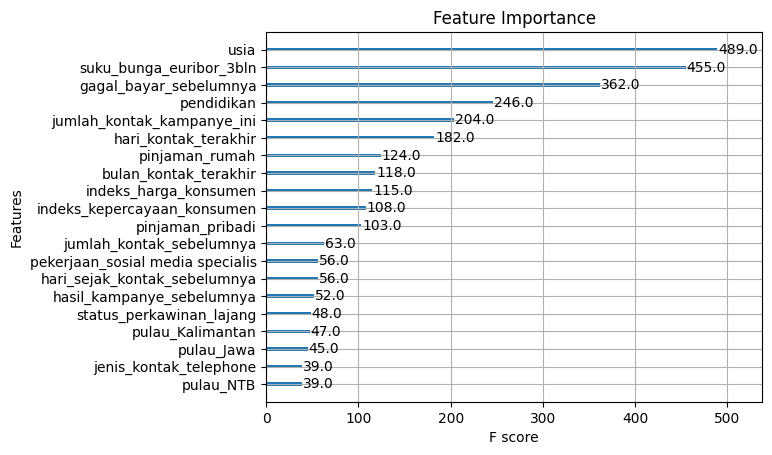

In [32]:
# Feature importance
explainer = shap.Explainer(model1)
shap_values = explainer.shap_values(X_val_scaled)
shap.summary_plot(shap_values, X_val_scaled, plot_type="bar", max_display=20)

plot_importance(model1, max_num_features=20, importance_type='weight', title='Feature Importance')


## Optuna

In [33]:
# import optuna
# from sklearn.model_selection import StratifiedKFold

# def objective(trial):
#     """
#     Objective function untuk optimasi hyperparameter CatBoostClassifier.
#     Fungsi ini akan dievaluasi oleh Optuna pada setiap trial.
#     """
#     # Definisikan ruang pencarian hyperparameter
#     param = {
#         'objective': trial.suggest_categorical('objective', ['Logloss', 'CrossEntropy']), # Tujuan training
#         'iterations': trial.suggest_int('iterations', 200, 1500), # Jumlah pohon
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
#         'depth': trial.suggest_int('depth', 3, 10), # Kedalaman pohon
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True), # Koefisien regulasi L2
#         'border_count': trial.suggest_int('border_count', 32, 255), # Jumlah split untuk fitur numerik
#         'random_strength': trial.suggest_float('random_strength', 1e-9, 1.0, log=True), # Untuk regularisasi, mencegah overfitting
#         'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0), # Kontrol intensitas bagging
#         # 'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.5, 2.0), # Untuk data tidak seimbang (opsional)
#         'verbose': 0, # Matikan output CatBoost selama training di Optuna
#         'early_stopping_rounds': 50, # Hentikan training jika tidak ada peningkatan setelah N iterasi
#         'random_seed': 42 # Untuk reproduktifitas dalam CatBoost
#     }

#     # Menggunakan Stratified K-Fold Cross-Validation untuk evaluasi yang lebih robust
#     # Anda bisa juga menggunakan train_test_split sederhana di sini jika dataset besar atau untuk kecepatan
#     skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=trial.number) # Gunakan trial.number agar random_state berbeda tiap trial jika diinginkan
#     # atau random_state=42 untuk konsistensi penuh
    
#     auc_scores = []

#     # Convert X and y to numpy arrays if they're pandas DataFrames or Series
#     X_array = X.values if isinstance(X, pd.DataFrame) else X
#     y_array = y.values if isinstance(y, pd.Series) else y
    
#     for fold, (train_idx, val_idx) in enumerate(skf.split(X_array, y_array)):
#         X_train, X_val = X_array[train_idx], X_array[val_idx]
#         y_train, y_val = y_array[train_idx], y_array[val_idx]

#         X_train = robust.fit_transform(X_train)
#         X_val = robust.transform(X_val)
#         X_train = pd.DataFrame(X_train, columns=X.columns if hasattr(X, 'columns') else None)
#         X_val = pd.DataFrame(X_val, columns=X.columns if hasattr(X, 'columns') else None)
        

#         model = CatBoostClassifier(**param)
        
#         # Penting: eval_set digunakan untuk early stopping
#         model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=param['early_stopping_rounds'], verbose=0)
        
#         # Prediksi probabilitas untuk kelas positif
#         preds_proba = model.predict_proba(X_val)[:, 1]
#         auc = roc_auc_score(y_val, preds_proba)
#         auc_scores.append(auc)

#     # Kembalikan rata-rata metrik dari semua fold
#     # Optuna akan mencoba memaksimalkan nilai ini karena direction='maximize'
#     return np.mean(auc_scores)

# # 3. Buat Studi Optuna dan Jalankan Optimasi
# # Arah optimasi bisa 'minimize' atau 'maximize' tergantung metrik yang Anda gunakan.
# # Untuk ROC AUC atau Akurasi, kita ingin 'maximize'.
# # Untuk LogLoss atau RMSE, kita ingin 'minimize'.
# study = optuna.create_study(direction='maximize', study_name='catboost_optimization_roc_auc')

# # `n_trials` adalah jumlah kombinasi hyperparameter yang akan dicoba.
# # Semakin banyak trial, semakin besar kemungkinan menemukan parameter yang baik, tapi semakin lama prosesnya.
# study.optimize(objective, n_trials=50, timeout=600) # timeout dalam detik (misalnya 10 menit)

# # 4. Tampilkan Hasil Terbaik
# print("\n===================================")
# print("Studi Optimasi Selesai.")
# print(f"Jumlah trial yang selesai: {len(study.trials)}")
# print(f"Trial terbaik:")
# best_trial = study.best_trial
# print(f"  Value (ROC AUC): {best_trial.value:.4f}")
# print(f"  Params: ")
# for key, value in best_trial.params.items():
#     print(f"    {key}: {value}")

# # 5. (Opsional) Latih Model Final dengan Parameter Terbaik pada Seluruh Data Training
# print("\n===================================")
# print("Melatih model final dengan parameter terbaik pada seluruh data training...")

# # Get best parameters from the study
# final_model_params = best_trial.params.copy()
# # Add additional parameters that were fixed in the objective function
# final_model_params['verbose'] = 0
# final_model_params['early_stopping_rounds'] = 50
# final_model_params['random_seed'] = 42

# print("Parameters untuk model final:")
# for key, value in final_model_params.items():
#     print(f"  {key}: {value}")

# # Ensure X and y are in proper format for train_test_split
# X_array = X.values if isinstance(X, pd.DataFrame) else X
# y_array = y.values if isinstance(y, pd.Series) else y

# X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_array, y_array, test_size=0.2, random_state=42, stratify=y_array)

# # Scale the data like in cross-validation phase
# X_train_final = robust.fit_transform(X_train_final)
# X_val_final = robust.transform(X_val_final)
# X_train_final = pd.DataFrame(X_train_final, columns=X.columns if hasattr(X, 'columns') else None)
# X_val_final = pd.DataFrame(X_val_final, columns=X.columns if hasattr(X, 'columns') else None)

# final_model = CatBoostClassifier(**final_model_params)
# final_model.fit(X_train_final, y_train_final,
#                 eval_set=[(X_val_final, y_val_final)], # Gunakan eval_set untuk model final juga
#                 verbose=final_model_params.get('verbose', 0) # Pastikan verbose diset
#                 )

# print("\nModel final telah dilatih.")
# # Anda kemudian dapat menyimpan model ini atau menggunakannya untuk prediksi pada data baru.
# # Misalnya, evaluasi pada set validasi final:
# final_preds_proba = final_model.predict_proba(X_val_final)[:, 1]
# final_auc = roc_auc_score(y_val_final, final_preds_proba)
# print(f"ROC AUC model final pada validation set-nya: {final_auc:.4f}")

# Predict on test

In [34]:
customer_col = pd.read_csv('D:/Data Quest Challenge DSI/validation_set.csv')['customer_number']

prediction = model2.predict_proba(test_scaled)[:, 1]
submission = pd.DataFrame({
    'customer_number': customer_col,
    'berlangganan_deposito': prediction
})
submission.to_csv('submission2.csv', index=False)